In [1]:
%load_ext lab_black

# respyabc

--- 
Project for the course in Scientific Computing | Winter 2020/2021, M.Sc. Economics, Bonn University | [Manuel Huth](https://github.com/manuhuth)
 
---

In this notebook I use the *pyabc* package to estimate the model from *Keane and Wolpin* 1994 using the *respy* package.

> Emmanuel Klinger, Dennis Rickert, Jan Hasenauer (2018); pyABC: distributed, likelihood-free inference. Bioinformatics.

> Janos Gabler, Tobias Raabe (2020); respy - A framework for the simulation and estimation of Eckstein-Keane-Wolpin models.

#### Using respyabc

* Clone from [GitHub](https://github.com/manuhuth/respyabc) or install via [conda](https://conda.anaconda.org/manuhuth)

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introduction-to-main-packages" data-toc-modified-id="1.-Introduction-to-main-packages-1">1. Introduction to main packages</a></span><ul class="toc-item">
<li><span><a href="#1.1-pyabc" data-toc-modified-id="1.1-pyabc-1.1">1.1 pyabc</a></span></li> 
<li><span><a href="#1.2-respy" data-toc-modified-id="1.2-respy">1.2 respy</a></span></li></li>

Loading all modules and functions is simply done by

In [2]:
import respy as rp
import pyabc
import numpy as np
import matplotlib.pyplot as plt

import time
import warnings

from pyabc.visualization import plot_kde_matrix_highlevel
from pyabc.visualization import plot_model_probabilities
from respyabc.distances import compute_mean_squared_distance
from respyabc.evaluation import compute_point_estimate
from respyabc.evaluation import plot_2d_histogram
from respyabc.evaluation import plot_history_summary
from respyabc.evaluation import plot_history_summary_no_kde
from respyabc.evaluation import plot_kernel_density_posterior
from respyabc.evaluation import plot_multiple_credible_intervals
from respyabc.models import compute_model
from respyabc.respyabc import respyabc
from respyabc.tools import convert_time
from respyabc.tools import plot_normal_densities

---
# 1 From respy and pyABC to respyabc
---

In this notebook I showcase the Python package respyabc, which offers a likelihood-free inference procedure for finite-horizon discrete choice models. The name arises from respy (Gabler and Raabe; [2020](https://respy.readthedocs.io/en/latest/)) and pyABC (Klinger et al.; [2018](https://watermark.silverchair.com/bty361.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAr0wggK5BgkqhkiG9w0BBwagggKqMIICpgIBADCCAp8GCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6WLi_HWh7fPxGjBoAgEQgIICcGn-J3-8gZEH93eB8Gphm7F3wCf9ux_fLjnoFR3ijbt06MKMNS0LPjKjApel0G5Ke2uZjYPBFRwC-aTWVQRLYNB2xpCRbHOzyPfYQrtoYlpmuHxy-JFAzxbwmv7DdOytmVwVyq6qGnx6Xzxls9nvdFdon1MPsCZ0Mj-x_Li6el_oGv0Eq9rY6Sd4QTicRuNCQ7Ci9GkXjDaSQR64hASP-dbUQjJUwlPsPTwUvGW8vTcHLP9LMj0gBaXvD3XM9MB0XtkNfGCBjxk1XmZV9bwJhD6FlI2AHfBGY3Avpusjjs3JPEL4HFt4DVVqhPWMD2TGgBGh9m62NDfV2-EH9bLc1XnTcWXk1FduyrNxomUmAsDgoSFAIndmVK2SS-wJC49iy1FnoCYt5l2XgLstI-0w9xcKNfMOks912e_S1rI1v012rgLydcybeyH--TcRl9tWjwKT_v4xwsTCMFpXnQqGOLa2HA93OuOpC9QHSmYaP2cp0a5Wq4seZArM28wYlF9D2nf0qjZRrlqqgLYXZmE_FEBStxiCeWMDYGq2t5A3w4buIqUsPepIQ70XJrwnIjUI8s0IAZUaQAqw2GRxtKLl-Q7qVj1YQnclN9E_LdioHe1_Er8KJoORZDARY_r1MWVn6o5TNWtgZhLyb-aoUbHnjgipUcZiXy-9NNZ122WcG4nVrms9eWQ5RC4boNdaEsBXxRKmuJUhtvgJswgrN9rUeidye7Ppqy13cD_LZwkYlDmKX9MAUnFj37X2kKtol1X84i3L_djRk2D20LhrDht9W4XwL5OK4SsEwRh_7GO8xP7hN57fttzHbMaV-qjg2K40EQ)], on which respyabc builds on.

**Model**\
respy is used to specify and simulate models in respyabc. Currently, the model of Keane and Wolpin [1994](https://www.jstor.org/stable/2109768?seq=1#metadata_info_tab_contents), which we abbreviate from here on with KW94, is the default standard. The incorporation of further and custom models is planned for the next release. We briefly sketch the KW94 model in this notebook to make the notebook self contained. A broader description of the model is given within [respy's doumentation](https://respy.readthedocs.io/en/latest/how_to_guides/specify_model.html).

There is a finite number of periods $t \in \{0, \dotsc, T \}$ in which an individual $i \in I$ decides between working in occupation A ($a=1$) or B ($a=2$), schooling ($a=3$) and staying at home ($a=4$). For each decision, an individual receives a choice-specific reward $R_a$ with

\begin{align}
R_1(t) &= w_{1t}=\exp{\left(\alpha_1 + \beta_{11} h_t + \gamma_{11} k_{1t} + \gamma_{12} k_{1t}^2 +  \gamma_{17} k_{2t} +  \gamma_{18} k_{2t}^2 + \varepsilon_{1t}  \right)} \\
R_2(t) &= w_{2t} = \exp{\left(\alpha_2 + \beta_{21} h_t + \gamma_{21} k_{2t} + \gamma_{22} k_{2t}^2 +  \gamma_{27} k_{1t} + \gamma_{28} k_{1t}^2 + \varepsilon_{2t}  \right)} \\
R_3(t) &= \alpha_3 + \beta_{tc} \mathbb{I}(h_t \geq 12) + \beta_{rc}[1-\mathbb{I}(a_{t-1} = 3)] + \varepsilon_{3t} \\
R_4(t) &= \alpha_4 + \varepsilon_{4t}.
\end{align}

$h_t$ denotes the years of schooling in period $t$ and $k_{a't}$ denotes the work experience in occupation $a' \in \{1,2\}$. Using squared terms within the exponential function of $R_1(t)$ and $R_2(t)$ allows for a parabola shape of work experience on logarithmic rewards, as in the popular Mincer [1974](https://eric.ed.gov/?id=ED103621) equation. $w_{a't}$ are wages that individuals earn from working in one of the two occupations.

$\mathbb{I}(h_t \geq 12)$ is an indicator function that indicates if an individual has 12 or more years of schooling experience. $\beta_{a'1}, \beta_{a'2}, \gamma_{a'1}, \gamma_{a'2}, \gamma_{a'7}$ and $\gamma_{a'8}$ are coefficients to determine the influence of years of schooling and working on the rewards of occupation. $\beta_{tc}$ is the coeffiicent of having 12 or more years of schooling and $\beta_{rc}$ is the reward of going back to school after at least one year of abscence. $\mathbb{I}(a_{t} = 3)$ is a dummy that is one if the individual attended school in period $t$.
$\alpha_a$ are choice specific reward constants. $\varepsilon_{at}$ are random shocks that can be correlated within a period $t$ and are a-priori  unknown to the individual.\
The optimizatzion problem that the forward-looking individual has to solve in any period $t$ is to maximize the expected sum of all discounted period utilities from period $t$ to period $T$. 

\begin{align}
v_t(s_t) = \mathbb{E} \left[\sum_{j=0}^{T-t} \delta^j u_{t+j}\left[s_{t+j}, a_{t+j}(s_{t+j})\right] \mid s_t  \right], 
\end{align}
where $s_t$ is the given state in period $t$ and $\delta \in (0,1]$ the discount factor. In respy, this optimization problem is solved using the principle of optimality (Bellmann 1954, 1957). With respy the user can calibarate her model by using empirical or simulated data of independent individuals via maximum likelihood estimation and estimation via the method of simulated moments. 
respyabc offers a likelihood-free alternative via approximate Bayesian computing (ABC) using a sequential Monte-Carlo (SMC) scheme. This is where pyABC comes into play. To go into more detail of pyABC, we first introduce some notation and define summary statistics of observed/simulated populations.

**Data summary statistics**
Let $Y^{q} \in \mathbb{R}^{(T+1) \times |I|}$ be the matrix collecting the observed/simulated outcome of interest $q$ for each individual $i \in I$ at all periods $t \in \{0, \dotsc, T \}$. Precisely, $y^q_{ti}$ is the entry in row $t$ and column $i$ of $Y^q$ and represents the outcome of interest $q$ for individual $i$ in period $t$. In our application, the outcome of interest are either the wages $w$ or the choices $a$, such that $q \in \{w, a \}$.
Let $s^q$ be a function that transforms the population data into chosen summary statistics $S^q = s^q(Y^q)$, with $S^q \in \mathbb{R}^{(T+1) \times \zeta^q}$ being a matrix containing $\zeta^q$ summary statistics of the population, measured at each period $t$.\
$s^a(Y^a)$ is defined to be the function that returns the choice frequencies of any alternative $a \in \{1,2,3,4\}$ for each period $t$. Hence, the $t$-th row of $S^a$ is defined as 
\begin{align}
\frac{1}{|I|}  \begin{pmatrix} \sum_{i = 1}^{|I|} \mathbb{I}(y^a_{ti} = 1) & \sum_{i = 1}^{|I|} \mathbb{I}(y^a_{ti} = 2) & \sum_{i = 1}^{|I|} \mathbb{I}(y^a_{ti} = 3) & \sum_{i = 1}^{|I|} \mathbb{I}(y^a_{ti} = 4) \end{pmatrix}'.
\end{align}
Thus, $\zeta^a = 4$. Analogously, $s^w(Y^w)$ is defined to be the function that returns the row means and row standard deviations of $Y^w$ as columns, such that the $t$-th row of $S^w$ is defined as
\begin{align}
\begin{pmatrix} \overline{y}^w_{t} & \frac{1}{|I|-1} \sum_{i = 1}^{|I|} \left(y^a_{ti} - \overline{y}^w_{t} \right)  \end{pmatrix}',
\end{align}
where $\overline{y}^w_{t}=\frac{1}{|I|}  \sum_{i = 1}^{|I|} y^w_{ti}$
Thus, $\zeta^w = 2$. 

**pyABC**
We can see one simulation of the KW94 model as a mapping $\mathcal{M}^q$ from a $d$- dimensional input vector $\theta \in \Theta \subset \mathbb{R}^n$, with parameter space $\Theta$, to chosen summary statistics of the simulated data $q$ 
\begin{align}
S^q = s^q(Y^q) =\mathcal{M}^q(\theta). 
\end{align}
$\theta$ consists in general of (some of) the $\alpha, \beta$ and $\gamma$ coefficients presented above. Additionally, the correlations and standard deviations of the period specific disturbances $\varepsilon_{at}$ and the discount factor can be seen as parameters. Note that we do not have to vary over all parameters and can interpret some of the parameters as fixed. Thus, $1 \leq d \leq 31$ for the K&W94 model. 

For inference purposes, we are interested in the likelihood of the parameters given the observed data $Y^q$. This likelihood is reflected by the *posterior distribution* $p(\theta|Y^q)$. We can describe the posterior distribution in terms of the *likelihood* $f(Y^q| \theta)$ and the *prior distribution* $\pi(\theta)$
\begin{align}
    p(\theta|Y^q) = \frac{f(Y^q| \theta) \pi(\theta) }{\int f(Y^q| \theta') \pi(\theta') d\theta'}.
\end{align}
For complicated $\mathcal{M}^q$ there is no closed form solution of the posterior and numerical algorithms are too costly or the posterior is not traceable at all. In these cases we can use ABC to estimate parameters likelihood-free.

The idea is to sample parameters $\theta$ such that the simulated model output $\hat{Y}^q$ is *close* to the observed data $Y^q$. For computational convenience, we do not use the data of $Y^q$ and $\hat{Y}^q$ but their summary statistics $S^q$ and $\hat{S}^q$ instead. To define what being *close* means for the matrices of summary statistics, we need to define a suitable distance $d^q:\mathbb{R}^{(T+1) \times \zeta^q} \times \mathbb{R}^{(T+1) \times \zeta^q} \to \mathbb{R_+}$. In our application, we use the averaged squared Frobenius-Norm of the differences between both matrices, which is just the mean of the squarred differences in each cell of the summary matrices. A simulated output $\hat{Y}_j^q$ is defined to be close to $Y^q$ if $d(S^q, \hat{S}_j^q) < \epsilon$ for a fixed small $\epsilon > 0$.

\begin{align}
    p(\theta|S^q) = \frac{f(S^q| \theta) \pi(\theta) }{p(S^q)} \approx \frac{\int  f(S| \theta) \pi(\theta) \mathbb{I}\left[d(S^q,S) < \epsilon \right] dS}{p(S^q)} = p_\epsilon(\theta|S^q),
\end{align}
such that $\lim\limits_{\epsilon \to 0} p_\epsilon(\theta|S^q) = p(\theta|S^q)$. 

In the abc-smc algorithm we simulate whole populations of simulated parameters $\{\hat{\theta}_{ij}^q\}_{i=0, \dotsc, n}^{j=0, \dotsc, p_j}$, where $i$ indicates the simulation iteration and $j$ indicates the $j$-th simulated accepted data, to approximate the true parameters. Note that the population size $p_j$ has a subscript $j$, since it usually varies over the iterations. You can find a note on that in Klinger et al. [2018](https://watermark.silverchair.com/bty361.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAAr0wggK5BgkqhkiG9w0BBwagggKqMIICpgIBADCCAp8GCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQM6WLi_HWh7fPxGjBoAgEQgIICcGn-J3-8gZEH93eB8Gphm7F3wCf9ux_fLjnoFR3ijbt06MKMNS0LPjKjApel0G5Ke2uZjYPBFRwC-aTWVQRLYNB2xpCRbHOzyPfYQrtoYlpmuHxy-JFAzxbwmv7DdOytmVwVyq6qGnx6Xzxls9nvdFdon1MPsCZ0Mj-x_Li6el_oGv0Eq9rY6Sd4QTicRuNCQ7Ci9GkXjDaSQR64hASP-dbUQjJUwlPsPTwUvGW8vTcHLP9LMj0gBaXvD3XM9MB0XtkNfGCBjxk1XmZV9bwJhD6FlI2AHfBGY3Avpusjjs3JPEL4HFt4DVVqhPWMD2TGgBGh9m62NDfV2-EH9bLc1XnTcWXk1FduyrNxomUmAsDgoSFAIndmVK2SS-wJC49iy1FnoCYt5l2XgLstI-0w9xcKNfMOks912e_S1rI1v012rgLydcybeyH--TcRl9tWjwKT_v4xwsTCMFpXnQqGOLa2HA93OuOpC9QHSmYaP2cp0a5Wq4seZArM28wYlF9D2nf0qjZRrlqqgLYXZmE_FEBStxiCeWMDYGq2t5A3w4buIqUsPepIQ70XJrwnIjUI8s0IAZUaQAqw2GRxtKLl-Q7qVj1YQnclN9E_LdioHe1_Er8KJoORZDARY_r1MWVn6o5TNWtgZhLyb-aoUbHnjgipUcZiXy-9NNZ122WcG4nVrms9eWQ5RC4boNdaEsBXxRKmuJUhtvgJswgrN9rUeidye7Ppqy13cD_LZwkYlDmKX9MAUnFj37X2kKtol1X84i3L_djRk2D20LhrDht9W4XwL5OK4SsEwRh_7GO8xP7hN57fttzHbMaV-qjg2K40EQ). The iterative abc-smc procedure works as follows (Toni et al.; [2008](https://royalsocietypublishing.org/doi/10.1098/rsif.2008.0172))

1. Initialize run. \
    1.1 Draw candidates $\theta_{0j}$ unconditionally from the prior distribution and accept if $d^q\left(\hat{S}_{0j}^q, S^q\right) < \epsilon_0$. Repeat until $p_0$ simulations have been accepted and set them as initial population $\hat{\theta}_0 = \left\{\hat{\theta}_{01}^q, \dotsc, \hat{\theta}_{0p_0}^q \right\}$.\
    1.2 Set weights $\omega_{0j} = 1/p_0$ 
2. Set $\epsilon_1$ to the median distance of the previous population.\
    2.1 Sample $\theta_{1j}$ from $\hat{\theta}_0$ with weights $\omega_0$ and perturb it with a perturbation kernel $K_1$. Accept if $d^q\left(\hat{S}_{1j}^q, S^q\right) < \epsilon_1$. Repeat until $p_1$ simulations have been accepted and set them as population $\hat{\theta}_1 = \left\{\hat{\theta}_{11}^q, \dotsc, \hat{\theta}_{1p_1}^q \right\}$.\
    2.2 Set weights to $\omega_{1j} = \frac{\pi(\theta_{1j})}{\sum_{j=1}^{p_1} \omega_{0j} K_1\left(\theta_{1j}, \theta_{0j}\right)}$ and normalize them such that their sum equals one.
3. Proceed with the same procedure until the $n$-th population $\hat{\theta}_n = \left\{\hat{\theta}_{n1}^q, \dotsc, \hat{\theta}_{np_n}^q \right\}$ is simulated using $\epsilon_n$.

In respyabc the user needs to define $\epsilon_n$, which is to say, the minimum epsilon and therefore the acceptance threshold. The acceptance rate is off course very sensitive to the choice of $\epsilon_n$. On the one hand, if $\epsilon_n$ is too large the approximation error is too high and we tend to accept samples generated by parameters that are far away from the true ones. On the other hand, if $\epsilon_n$ is too small, we might decline too many samples and the algorithm has a hard time computing estimates. 

## KW94model settings

We use respy to load the settings of the KW94 model and inspect the true parameter we will use to get on overview of the magnitudes we vary over.

In [4]:
params, options, data_stored = rp.get_example_model("kw_94_one")

In [5]:
params

value  \
category            name                                  
delta               delta                        0.9500   
wage_a              constant                     9.2100   
                    exp_edu                      0.0380   
                    exp_a                        0.0330   
                    exp_a_square                -0.0005   
                    exp_b                        0.0000   
                    exp_b_square                 0.0000   
wage_b              constant                     8.4800   
                    exp_edu                      0.0700   
                    exp_b                        0.0670   
                    exp_b_square                -0.0010   
                    exp_a                        0.0220   
                    exp_a_square                -0.0005   
nonpec_edu          constant                     0.0000   
                    at_least_twelve_exp_edu      0.0000   
                    not_edu_last_period      -4000.0000   
nonpec_home         constant                 17750.0000   
shocks_sdcorr       sd_a                         0.2000   
                    sd_b                         0.2500   
                    sd_edu                    1500.0000   
                    sd_home                   1500.0000   
                    corr_b_a                     0.0000   
                    corr_edu_a                   0.0000   
                    corr_edu_b                   0.0000   
                    corr_home_a                  0.0000   
                    corr_home_b                  0.0000   
                    corr_home_edu                0.0000   
lagged_choice_1_edu probability                  1.0000   
initial_exp_edu_10  probability                  1.0000   
maximum_exp         edu                         20.0000   

                                                                                       comment  
category            name                                                                        
delta               delta                                                      discount factor  
wage_a              constant                                               log of rental price  
                    exp_edu                          return to an additional year of schooling  
                    exp_a                                     return to same sector experience  
                    exp_a_square                   return to same sector, quadratic experience  
                    exp_b                                    return to other sector experience  
                    exp_b_square                  return to other sector, quadratic experience  
wage_b              constant                                               log of rental price  
                    exp_edu                          return to an additional year of schooling  
                    exp_b                                     return to same sector experience  
                    exp_b_square                   return to same sector, quadratic experience  
                    exp_a                                    return to other sector experience  
                    exp_a_square                  return to other sector, quadratic experience  
nonpec_edu          constant                            constant reward for choosing education  
                    at_least_twelve_exp_edu        reward for going to college (tuition, etc.)  
                    not_edu_last_period                        reward for going back to school  
nonpec_home         constant                         constant reward of non-market alternative  
shocks_sdcorr       sd_a                     Element 1,1 of standard-deviation/correlation ...  
                    sd_b                     Element 2,2 of standard-deviation/correlation ...  
                    sd_edu                   Element 3,3 of standard-deviation/correlation ...  
                    sd_home

To run respyabc efficiently, it is necessary that the distance $d^q(\cdot)$ we observe is (close to) zero if we simualte the model with the true parameter vector $\theta$. Hence, we want that $\mathcal{M}^q(\theta)=S^q$ is invariant to the choice of the random simulation seed. We achieve this in the KW94 setting by choosing a suitable large number of individuals and decision periods, such that the summary statistics are invariant to the seeds. We keep the standards of $T=40$ simulated periods and $|I|=1000$ individuals for each run of the KW94 model. We showcase in this notebook for every abc specification that this condition is met. 

In [6]:
periods = options["n_periods"]
agents = options["simulation_agents"]
print(
    f"The default setting of KW94 consists of {periods} periods and {agents} independent agents."
)

The default setting of KW94 consists of 40 periods and 1000 independent agents.


---
# 2 Inference
---

## 2.1 Single parameter

In this subsecton we will vary over the discount factor delta, which is in the KW94 model set to $\delta = 0.95$, such that the model of interest becomes $\mathcal{M}^q(\delta)=S^q$. We will compare how respyabc performs for $q=a,w$.

To simulate the true population in respyabc we need to define the model that is to be simulated, the magnitude of the parameter of interest $\delta$, choose between $d^a(\cdot)$ and $d^w(\cdot)$ to compute the distance between 2 populations. Naming the parameter `delta_delta` seems to be unnecassarily cumbersome in the first place. However, note that `params` is a multi-indexed data frame but pyABC only works with single-indexed data. Thus, respyabc melts both indices to an index and divides them by an underscore, such that the parameter key and the data frame index can be called within one string but the parameter is still uniquely identified in `params`. The parameters are, according to pyABC, defined in a dictionary.

In [7]:
model_to_simulate = rp.get_simulate_func(params, options)
parameter_true_single_delta_a = {"delta_delta": 0.95}

### 2.1.1 Using choice frequencies

In this first example we will use $q=a$. This is passed to respyabc by `descriptives="choice_frequencies"`. Moreover, respyabc allows to modify the parameter values over which we do not vary and the custom options. However, we set them to their true values by `parameter_for_simulation=params` and `options_for_simulation=options`.

In [8]:
np.random.seed(12)
pseudo_observed_data_a = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

To varify that $\mathcal{M}^q(\delta)$ is invariant to the seed, we run the simulation again using a different seed.

In [9]:
np.random.seed(123)
pseudo_observed_data_a_test = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="choice_frequencies",
)

In [10]:
seed_distance_a = compute_mean_squared_distance(
    pseudo_observed_data_a_test, pseudo_observed_data_a
)
print(
    f"The distance of two model runs with the same parameters is: {seed_distance_a :0.2f}"
)

The distance of two model runs with the same parameters is: 0.00


We set the size of the pyABC samples to 500 and the maximum possible number of drawn populations $n=10$. The excact magnitudes in applications depend on the respective application. In general, if a rigorous analysis is desired, the maximum number of drawn pyABC populations should not be reached, since this tool is more for convenience to reduce computation time and give the user the possibility to check the results.

In [11]:
population_size = 50
max_nr_populations = 10

The $\epsilon_n$ is set to be 0.05. This was found to be a valid epsilon in previous simulations. Choosing a uniform prior has the advantage that the user implicitly sets bounds on the posterior distribution and every value has the same prior density.

In [12]:
minimum_epsilon = 0.05
delta_prior_low_single_delta_a = 0.9
delta_prior_length_single_delta_a = 0.09
parameters_prior_single_delta_a = {
    "delta_delta": [
        [delta_prior_low_single_delta_a, delta_prior_length_single_delta_a],
        "uniform",
    ]
}

The dictionary must be read as follow. `"delta_delta"` is the key identifier, `delta_prior_low_single_delta_a` is the lower bound of the uniform distribution and `delta_prior_length_single_delta_a` is the length of the uniform interval and **not** the upper bound. This is to be in line with the logic of `pyABC`, which follows `scipy`.  

After specifying all relevant parameters, inference is conducted by using the `respyabc` function. We keep track of the simulation time to give a first glimpse about the timing. 

In [13]:
np.random.seed(1234)
start_single_delta_a = time.perf_counter()
history_single_delta_a = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_single_delta_a,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_single_delta_a = time.perf_counter()

In [14]:
time_single_delta_a, unit_single_delta_a = convert_time(
    end_single_delta_a - start_single_delta_a
)
f"The respyabc run for delta using choice frequencies took {time_single_delta_a:0.2f} {unit_single_delta_a}"

'The respyabc run for delta using choice frequencies took 5.33 minutes'

We compute a point estimate as weighted average over the population with the smallest epsilon. This can be done using respyabc's `compute_point_estimate` function by passing the history object. **Explain if good or bad**

In [15]:
estimate_single_delta_a = compute_point_estimate(history_single_delta_a).loc[
    "estimate", "delta_delta"
]
f"The point estimate for delta is: {estimate_single_delta_a:0.4f}"

'The point estimate for delta is: 0.9502'

To compare how the estimated densities of the posterior estimates evolve, respyabc offer merged kernel density plots for every population via `plot_kernel_density_posterior`. 

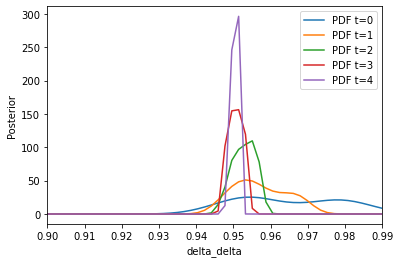

In [16]:
xmax_single_delta_a = delta_prior_low_single_delta_a + delta_prior_length_single_delta_a
plot_kernel_density_posterior(
    history=history_single_delta_a,
    parameter="delta_delta",
    xmin=delta_prior_low_single_delta_a,
    xmax=xmax_single_delta_a,
)

Since the function `respyabc` returns a [ABCSMC](https://pyabc.readthedocs.io/en/latest/api_inference.html) class, all model assessments tools from pyABC are feasible to apply as well. Hence, we can use the well implemented functions to track the evolution of $\epsilon$, the sample sizes and plot credible intervals. respyabc offers a wrapper `plot_history_summary` for a fast implementation.

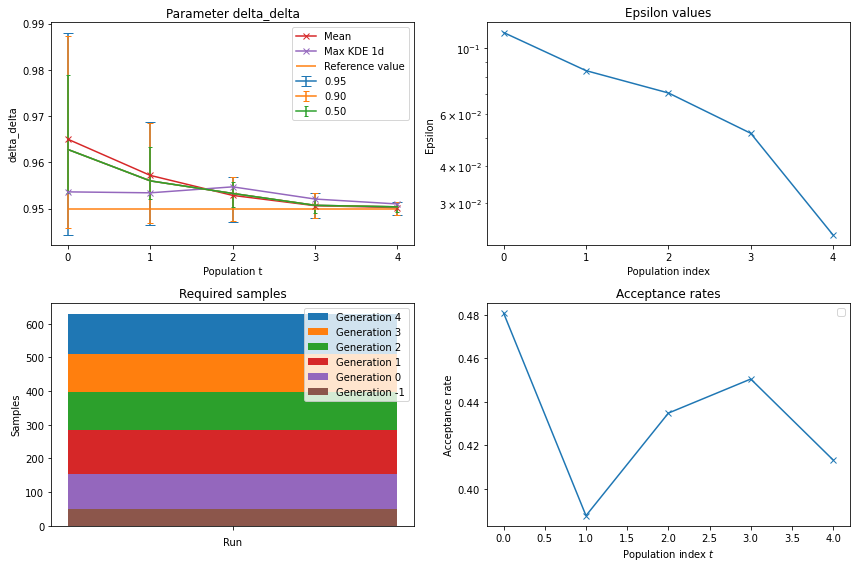

In [17]:
plot_history_summary(
    history=history_single_delta_a, parameter_name="delta_delta", parameter_value=0.95
)

**Describe plots**

### 2.1.2 Using wage moments

To use the wage moments, we first need to compute the exemplary data set with the wage moments as summary statistics. We can do so by setting `descriptives="wage_moments"`. All other parameters are equal to the specififcation using $S^a$. We set the same seed to obtain the same data. We furthermore compare the distance for another seed with the true parameters to see if the summary statistics are invariant to the seed.

In [18]:
np.random.seed(12)
pseudo_observed_data_single_delta_w = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="wage_moments",
)
np.random.seed(123)
pseudo_observed_data_single_delta_w_test = compute_model(
    parameter_true_single_delta_a,
    model_to_simulate=model_to_simulate,
    parameter_for_simulation=params,
    options_for_simulation=options,
    descriptives="wage_moments",
)

In [19]:
seed_distance_single_delta_w = compute_mean_squared_distance(
    pseudo_observed_data_single_delta_w_test, pseudo_observed_data_single_delta_w
)
print(
    f"The distance of two model runs with the same parameters is: {seed_distance_single_delta_w :0.2f}"
)

The distance of two model runs with the same parameters is: 0.00


Running the abc algorithm for the wage moments is again as easy as specifying the data `data=pseudo_observed_data_single_delta_w` and setting `descriptives="wage_moments"` in addition to the same parameters we used in the case of choice frequencies. We set $\epsilon_n=10^6$, which turned out to be reasonable high.

In [20]:
np.random.seed(1234)
start_single_delta_w = time.perf_counter()
history_single_delta_w = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_single_delta_a,
    data=pseudo_observed_data_single_delta_w,
    distance_abc=compute_mean_squared_distance,
    descriptives="wage_moments",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=10 ** 6,
)
end_single_delta_w = time.perf_counter()

In [21]:
estimate_single_delta_w = compute_point_estimate(history_single_delta_w).loc[
    "estimate", "delta_delta"
]
f"The point estimate for delta is: {estimate_single_delta_w:0.4f}"

'The point estimate for delta is: 0.9500'

In [22]:
time_single_delta_w, unit_single_delta_w = convert_time(
    end_single_delta_w - start_single_delta_w
)
f"The respyabc run for delta using choice frequencies took {time_single_delta_w:0.2f} {unit_single_delta_w}"

'The respyabc run for delta using choice frequencies took 5.93 minutes'

**Describe time and plots. Comapre with a run**. 

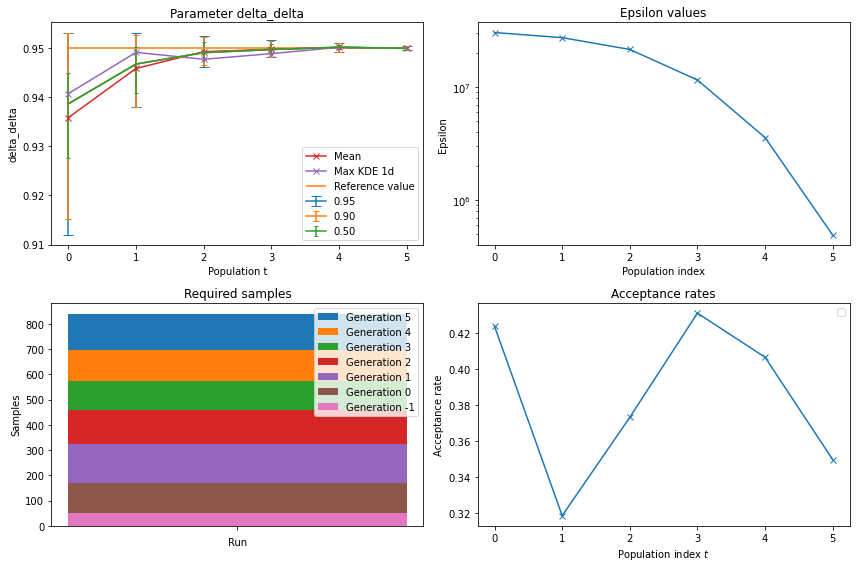

In [23]:
plot_history_summary(
    history=history_single_delta_w, parameter_name="delta_delta", parameter_value=0.95
)

## 2.2 Multiple parameters

- vary over work constants
- use choice frequencies
- normal priors -> as oppsoed to discount factor no clear bounds

### 2.2.1 Two parameters

We first vary over two parameters to showcase the transition from a single parameter model to a multiple parameter model. Our parameters of choice are the constants $\alpha_1$ and $\alpha_2$ from equations $R_1$ and $R_2$. We only use $q=a$ and thus focus on the model with choice frequencies as summary statistics $\mathcal{M}^a(\alpha_1, \alpha_2)$. Modifications to $q=w$ can be done analogously to the single parameter case.\
As in the single parameter case, we first define the true parameters. For multiple parameters, we can simply define them in one dictionary with the keys equal to the melted multiindex from the data frame `params` and the values equal to the desired magnitude. We stay within the original KW94 model and set them to $\alpha_1 = 9.21$ and $\alpha_2 = 8.48$.

Specifying the prior distributions requires specifying both parameters in one dictionary. 

In [24]:
parameters_prior_multi_alpha = {
    "wage_a_constant": [[9, 1], "uniform"],
    "wage_b_constant": [[8, 1], "uniform"],
}

Armed with the priors, running respyabc is equivalent to the previous runs.

In [25]:
np.random.seed(234)
start_multi_alpha = time.perf_counter()
history_multi_alpha = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_multi_alpha,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_multi_alpha = time.perf_counter()

In [26]:
time_multi_alpha, unit_multi_alpha = convert_time(end_multi_alpha - start_multi_alpha)
f"The respyabc run for delta using choice frequencies took {time_multi_alpha:0.2f} {unit_multi_alpha}"

'The respyabc run for delta using choice frequencies took 5.04 minutes'

**describe estimates** 

In [27]:
estimate_multi_alpha = compute_point_estimate(history_multi_alpha).loc["estimate", :]
estimate_multi_alpha

name
wage_a_constant    9.419827
wage_b_constant    8.693692
Name: estimate, dtype: float64

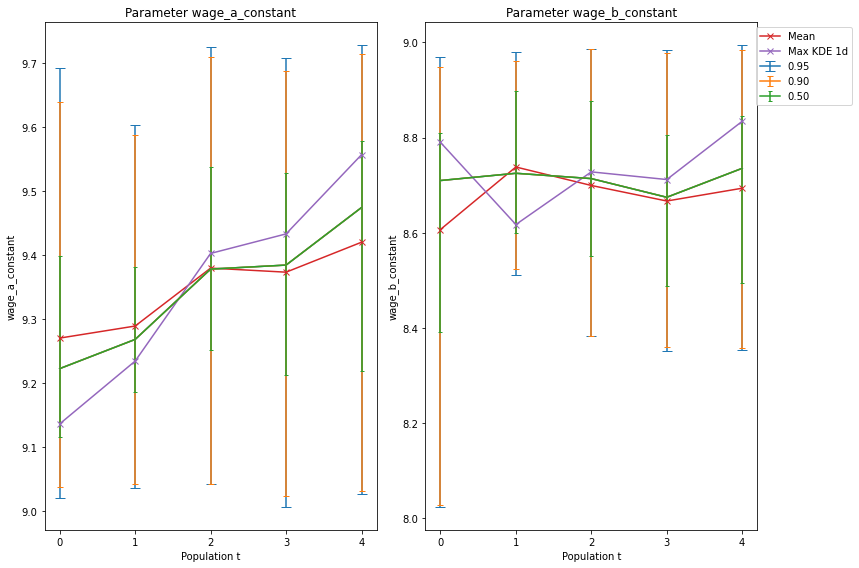

In [28]:
plot_multiple_credible_intervals(
    history=history_multi_alpha,
    number_rows=1,
    number_columns=2,
    parameter_names=["wage_a_constant", "wage_b_constant"],
)

/home/manuel/Documents/respyabc/respyabc/evaluation.py:462: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(3, ncol, t + 1)


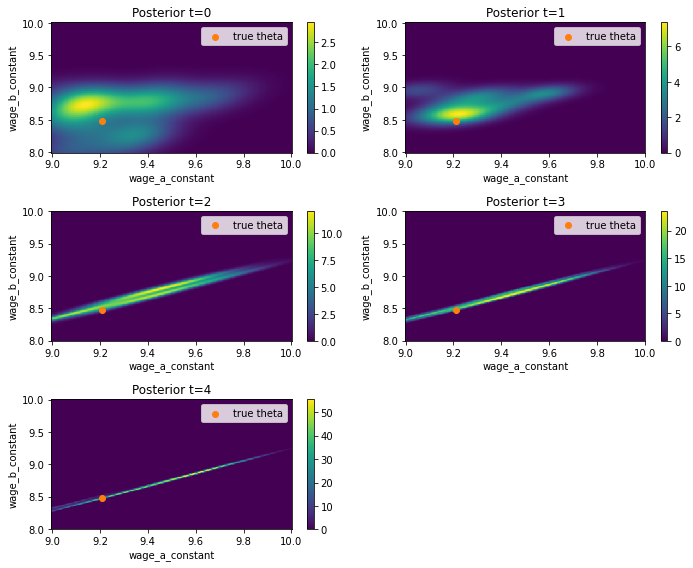

In [29]:
xmin = parameters_prior_multi_alpha["wage_a_constant"][0][0]
xmax = xmin + parameters_prior_multi_alpha["wage_a_constant"][0][1]
ymin = parameters_prior_multi_alpha["wage_b_constant"][0][0]
ymax = xmin + parameters_prior_multi_alpha["wage_b_constant"][0][1]

plot_2d_histogram(
    history=history_multi_alpha,
    parameter_names=["wage_a_constant", "wage_b_constant"],
    parameter_true=[9.21, 8.48],
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
)

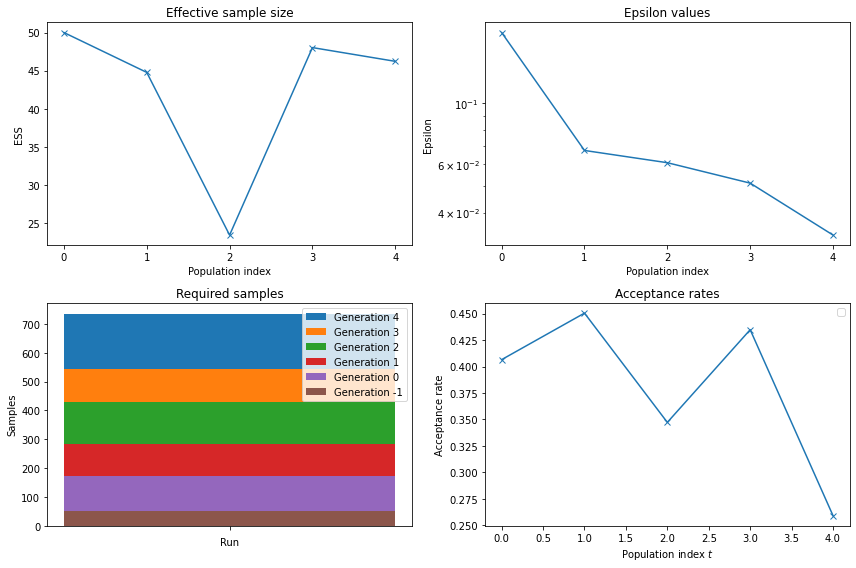

In [30]:
plot_history_summary_no_kde(history_multi_alpha)

**describe plots**

### 2.2.2 All non-zero parameters

- model
- kde matrix as in Multi-scale model: Tumor spheroid growth example

mathematically describe model (theta)

In [31]:
parameters_prior_multi = {
    "delta_delta": [
        [delta_prior_low_single_delta_a, delta_prior_length_single_delta_a],
        "uniform",
    ],
    "wage_a_constant": [
        [
            parameters_prior_multi_alpha["wage_a_constant"][0][0],
            parameters_prior_multi_alpha["wage_a_constant"][0][1],
        ],
        "uniform",
    ],
    "wage_a_exp_edu": [[0, 0.1], "uniform"],
    "wage_a_exp_a": [[0, 0.1], "uniform"],
    "wage_a_exp_a_square": [[-0.05, 0.05], "uniform"],
    "wage_b_constant": [
        [
            parameters_prior_multi_alpha["wage_b_constant"][0][0],
            parameters_prior_multi_alpha["wage_b_constant"][0][1],
        ],
        "uniform",
    ],
    "wage_b_exp_edu": [[0, 0.1], "uniform"],
    "wage_b_exp_b": [[0, 0.1], "uniform"],
    "wage_b_exp_b_square": [[-0.05, 0.05], "uniform"],
    "wage_b_exp_a": [[0, 0.1], "uniform"],
    "wage_b_exp_a_square": [[-0.05, 0.05], "uniform"],
}

In [32]:
np.random.seed(2345)
start_multi = time.perf_counter()
history_multi = respyabc(
    model=compute_model,
    parameters_prior=parameters_prior_multi,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
)
end_multi = time.perf_counter()

In [33]:
time_multi, unit_multi = convert_time(end_multi - start_multi)
f"The respyabc run for delta using choice frequencies took {time_multi:0.2f} {unit_multi}"

'The respyabc run for delta using choice frequencies took 8.44 minutes'

In [34]:
estimate_multi = compute_point_estimate(history_multi).loc["estimate", :]
estimate_multi

name
delta_delta            0.932793
wage_a_constant        9.525123
wage_a_exp_a           0.045336
wage_a_exp_a_square   -0.012952
wage_a_exp_edu         0.047129
wage_b_constant        8.839708
wage_b_exp_a           0.061129
wage_b_exp_a_square   -0.004166
wage_b_exp_b           0.059846
wage_b_exp_b_square   -0.003801
wage_b_exp_edu         0.082704
Name: estimate, dtype: float64

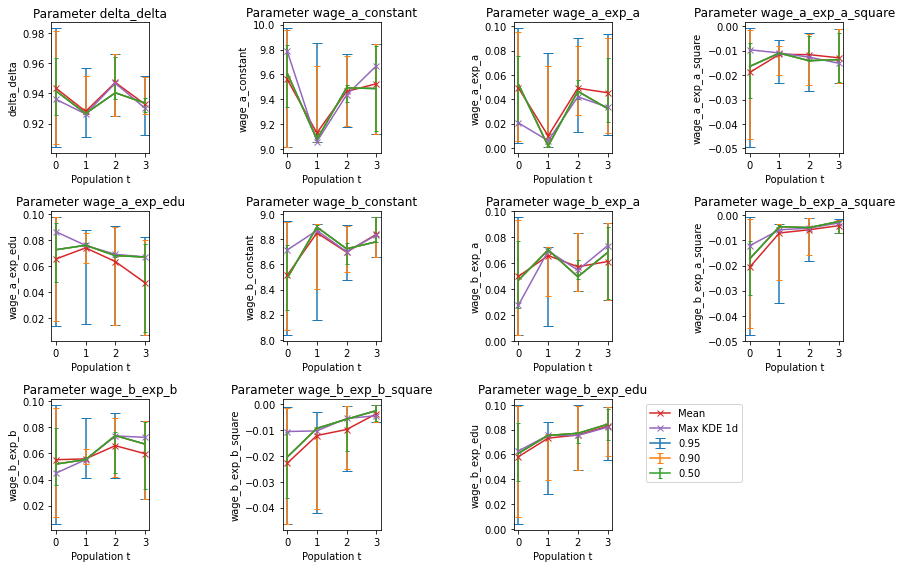

In [50]:
par_names = estimate_multi.index
plot_multiple_credible_intervals(
    history=history_multi,
    parameter_names=par_names,
    number_rows=3,
    number_columns=4,
    delete_axes=[2, 3],
    legend_location="lower_right",
)

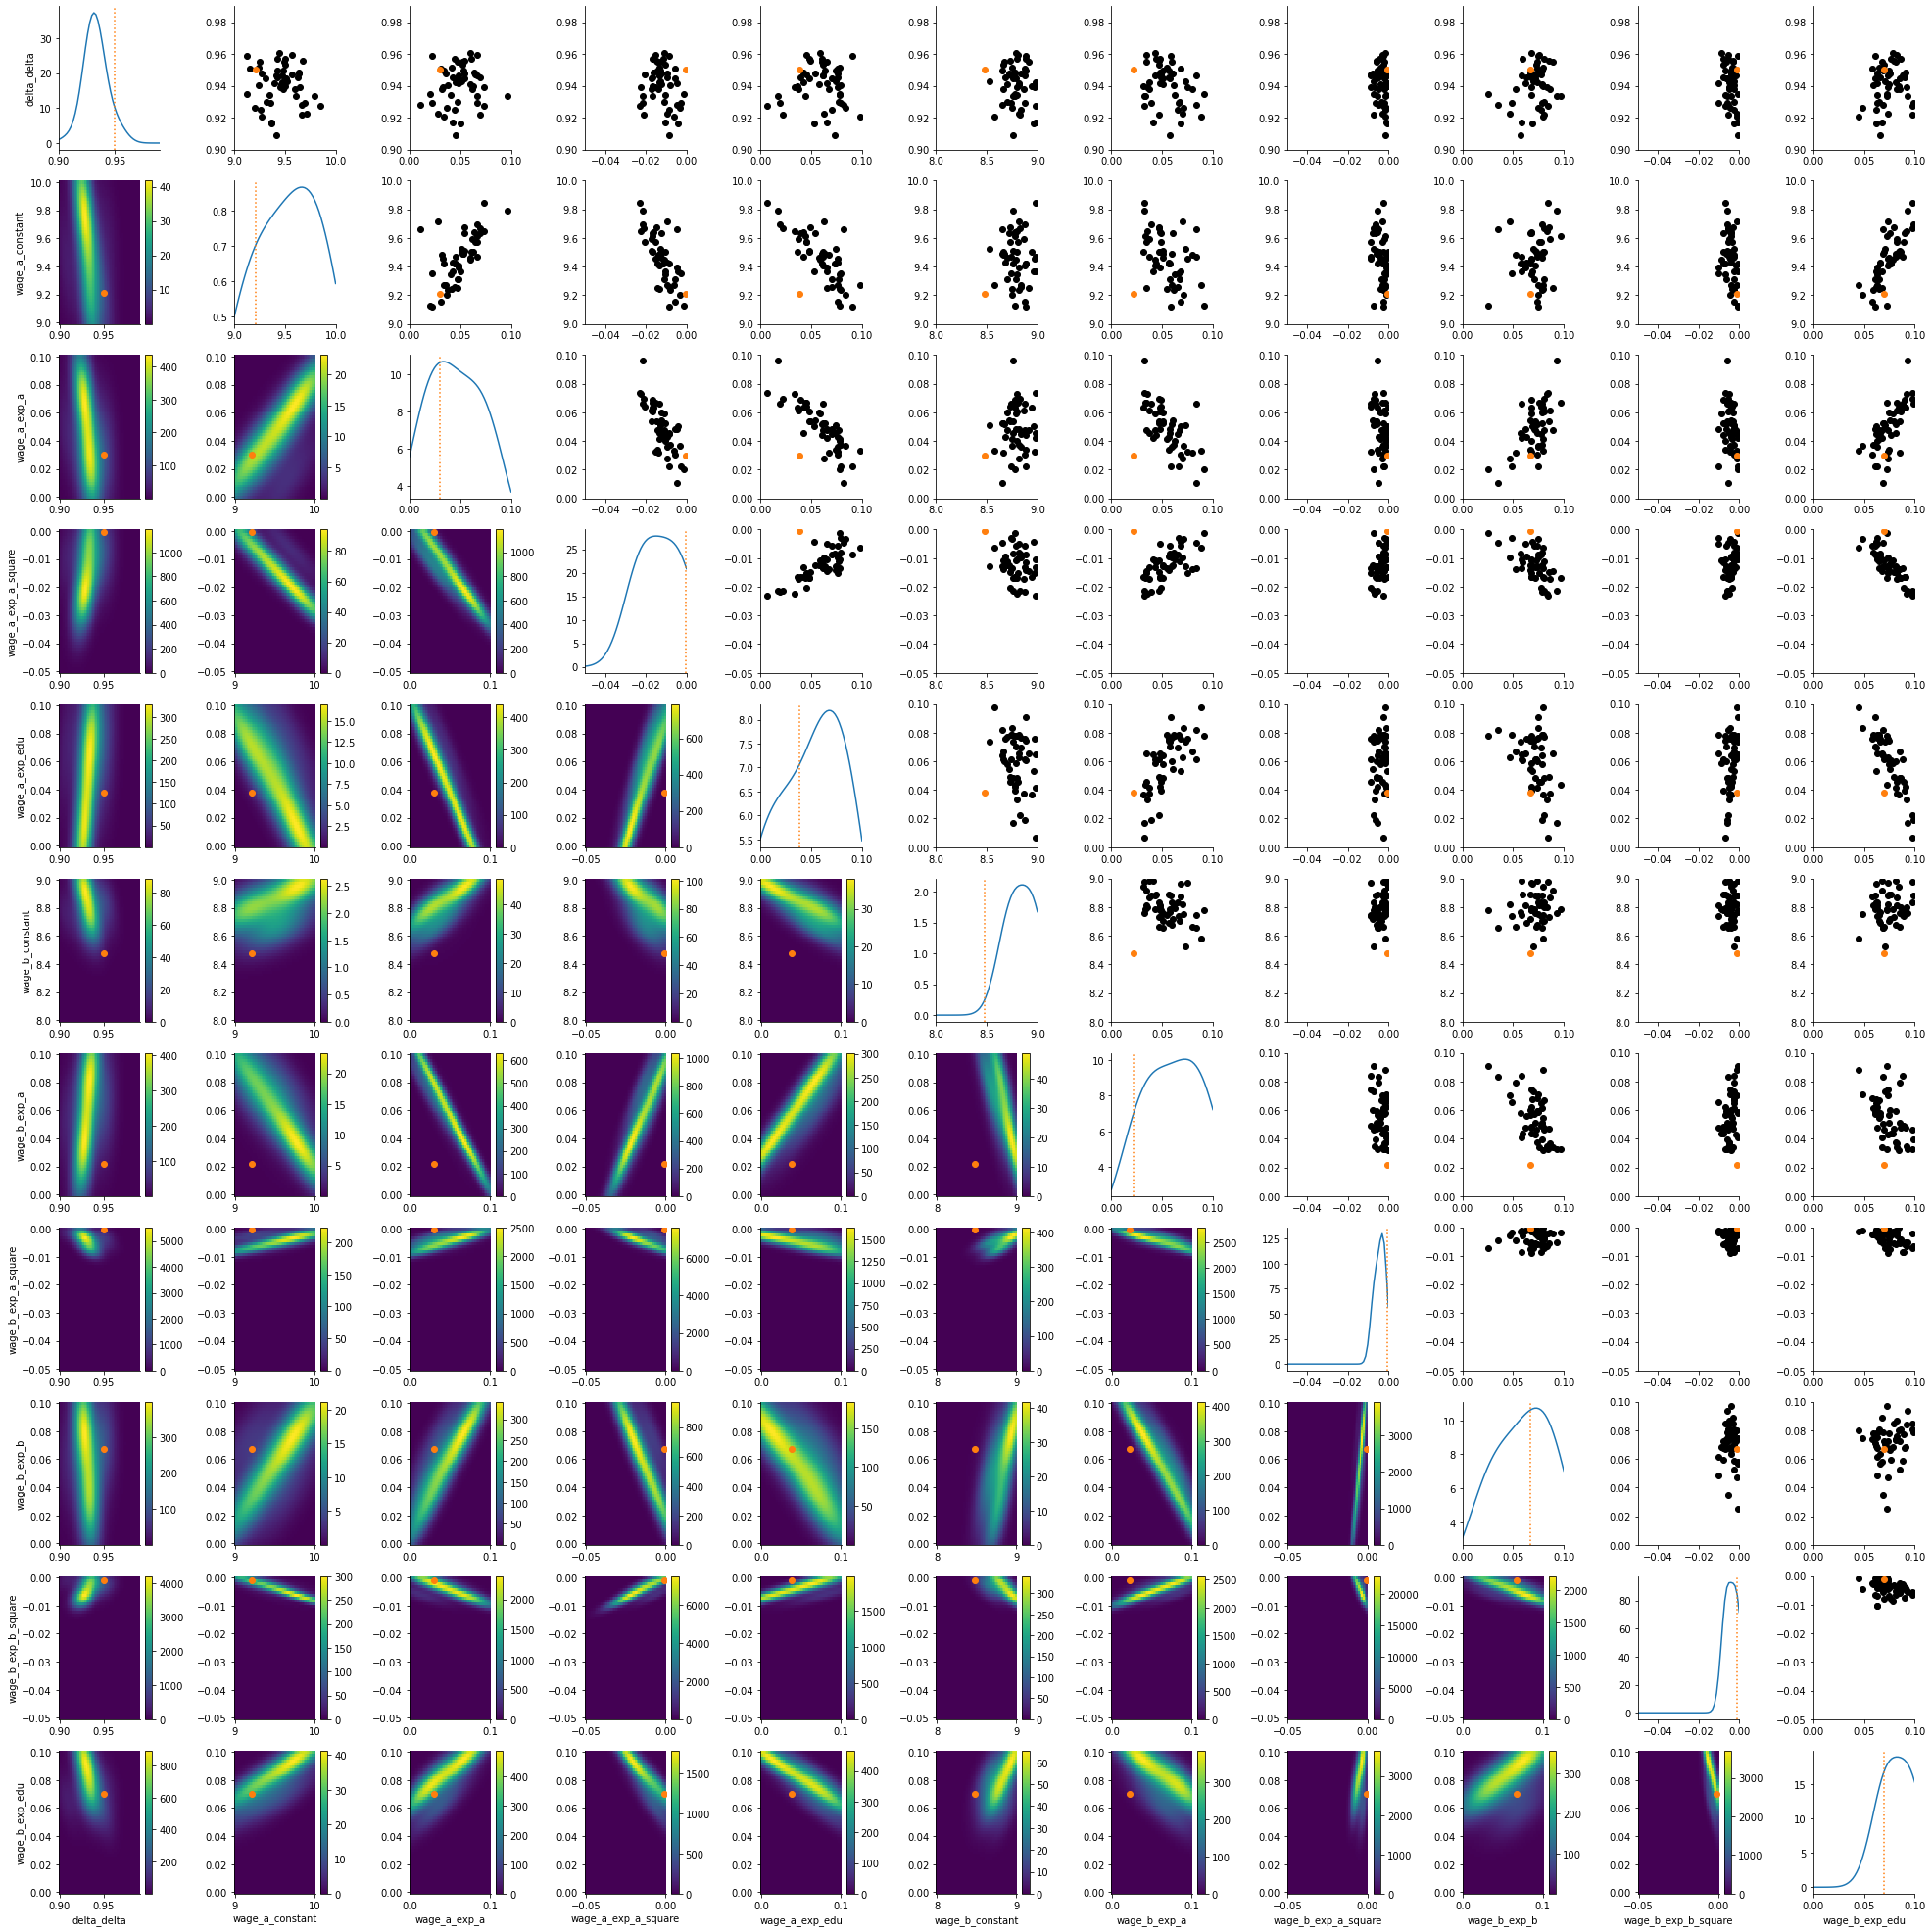

In [36]:
true_values = {
    "delta_delta": 0.95,
    "wage_a_constant": 9.21,
    "wage_a_exp_a": 0.03,
    "wage_a_exp_a_square": -0.0005,
    "wage_a_exp_edu": 0.038,
    "wage_b_constant": 8.48,
    "wage_b_exp_a": 0.0220,
    "wage_b_exp_a_square": -0.0005,
    "wage_b_exp_b": 0.0670,
    "wage_b_exp_b_square": -0.001,
    "wage_b_exp_edu": 0.07,
}
limits = {}
keys = parameters_prior_multi.keys()
for i in keys:
    limits[i] = (
        parameters_prior_multi[i][0][0],
        parameters_prior_multi[i][0][0] + parameters_prior_multi[i][0][1],
    )
kde_matrix = plot_kde_matrix_highlevel(history_multi, refval=true_values, limits=limits)

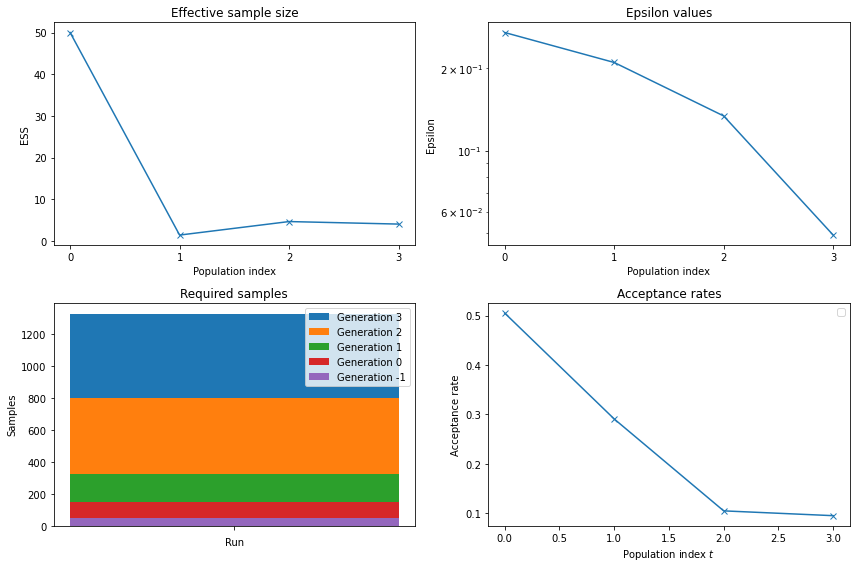

In [37]:
plot_history_summary_no_kde(history_multi)

# 3 Model selection
---

- compare model with one parameter and normal prior
- mention that this just a brief introduction. add section on that to theory part

In [44]:
models = [compute_model, compute_model]
parameter_selection = "wage_a_exp_edu"
mu1 = params.loc["wage_a", "exp_edu"][0] * 1
var1 = 0.004
mu2 = params.loc["wage_a", "exp_edu"][0] * 0.6
var2 = 0.004
parameter_prior_selection_model1 = {parameter_selection: [[mu1, var1], "norm"]}
parameter_prior_selection_model2 = {parameter_selection: [[mu2, var2], "norm"]}
parameter_prior_selection = [
    parameter_prior_selection_model1,
    parameter_prior_selection_model2,
]

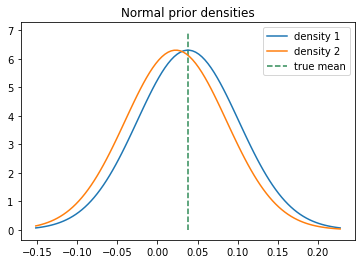

In [45]:
plot_normal_densities(
    mu1=mu1,
    var1=var1,
    mu2=mu2,
    var2=var2,
    vertical_marker=params.loc["wage_a", "exp_edu"][0],
)

In [46]:
np.random.seed(34)
start_selection = time.perf_counter()
history_selection = respyabc(
    model=models,
    parameters_prior=parameter_prior_selection,
    data=pseudo_observed_data_a,
    distance_abc=compute_mean_squared_distance,
    descriptives="choice_frequencies",
    population_size_abc=population_size,
    max_nr_populations_abc=max_nr_populations,
    minimum_epsilon_abc=minimum_epsilon,
    model_selection=True,
)
end_selection = time.perf_counter()

In [47]:
time_multi, unit_multi = convert_time(end_multi - start_multi)
f"The respyabc run for delta using choice frequencies took {time_multi:0.2f} {unit_multi}"

'The respyabc run for delta using choice frequencies took 8.44 minutes'

In [48]:
model_probabilities = history_selection.get_model_probabilities()
model_probabilities

m,0,1
t,,
0,0.520000,0.480000
1,0.938613,0.061387
2,1.000000,0.000000


<AxesSubplot:title={'center':'Model probabilities'}, xlabel='Population index', ylabel='Probability'>

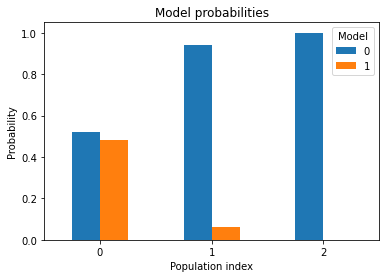

In [49]:
plot_model_probabilities(history_selection)

# 4 Concluision
---